In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

In [ ]:
# Load data
datapath = "/home/om2382/datasets/hemibrain_neurotransmitters-2/"
neurons = pd.read_csv(datapath + "traced-neurons_withnt_log.csv")
conns = pd.read_csv(datapath + "traced-total-connections.csv")
roi_conns = pd.read_csv(datapath + "traced-roi-connections.csv")

# List of neurotransmitter columns
nt_names = ['nts_8.gaba', 'nts_8.acetylcholine', 'nts_8.glutamate',
            'nts_8.serotonin', 'nts_8.octopamine', 'nts_8.dopamine', 
            'nts_8.neither']

# Sign of the effect of each neurotransmitter
nt_signs = {
    'nts_8.gaba': -1,          # Inhibitory
    'nts_8.acetylcholine': 1,  # Excitatory
    'nts_8.glutamate': -1,     # Inhibitory
    'nts_8.serotonin': 0,      # Ignore
    'nts_8.octopamine': 0,     # Ignore
    'nts_8.dopamine': 0,       # Ignore
    'nts_8.neither': 0         # Ignore
}

# Find the most likely neurotransmitter type for each neuron
max_nt_indices = neurons[nt_names].idxmax(axis=1)

# Filter out neurons with neurotransmitter types corresponding to sign zero
valid_indices = [i for i, nt in enumerate(max_nt_indices) if nt_signs[nt] != 0]

# Update neurons, conns, roi_conns, and max_nt_indices to only include valid neurons
neurons = neurons.iloc[valid_indices]
conns = conns[conns.bodyId_pre.isin(neurons.bodyId) & conns.bodyId_post.isin(neurons.bodyId)]
roi_conns = roi_conns[roi_conns.bodyId_pre.isin(neurons.bodyId) & roi_conns.bodyId_post.isin(neurons.bodyId)]
max_nt_indices = max_nt_indices[valid_indices]

# Update types and instances
types = np.array(neurons['type']).astype(str)  # cell type
instances = np.array(neurons['type']).astype(str)  # more descriptive cell name

# Define N as the number of valid neurons
N = len(neurons)
J = np.zeros([N, N], dtype=np.float32)  # Use float to handle weighted connections

# Create a dictionary to map neuron bodyId to index
idhash = dict(zip(neurons.bodyId, np.arange(N)))

# Map pre and post synaptic bodyIds to indices
preinds = [idhash[x] for x in conns.bodyId_pre]
postinds = [idhash[x] for x in conns.bodyId_post]

# Populate the connection matrix J
J[postinds, preinds] = conns.weight

# Apply the neurotransmitter signs to the matrix J
for j, nt in enumerate(max_nt_indices):
    effect = nt_signs[nt]
    J[:, j] *= effect

# Analyze ROI connections
roi_conns['pre_index'] = roi_conns.bodyId_pre.map(idhash)
roi_conns['post_index'] = roi_conns.bodyId_post.map(idhash)

# Initialize arrays to hold the most connected ROI for each neuron
nrn_roi_outgoing = np.full(N, '', dtype='<U50')  # ROI names are less than 50 characters
nrn_roi_incoming = np.full(N, '', dtype='<U50')

# ROI in which each neuron makes the most number of connections
most_pre_roi_series = roi_conns.groupby(['pre_index', 'roi'])['weight'].sum().unstack(fill_value=0).idxmax(axis=1)
nrn_roi_outgoing[most_pre_roi_series.index] = most_pre_roi_series.values

# ROI in which each neuron receives the most number of connections
most_post_roi_series = roi_conns.groupby(['post_index', 'roi'])['weight'].sum().unstack(fill_value=0).idxmax(axis=1)
nrn_roi_incoming[most_post_roi_series.index] = most_post_roi_series.values

# Normalize rows (l2 norm = 1)
norms_row = np.linalg.norm(J, axis=1)
norms_row[norms_row == 0] = 1.
J_norm_row = J / norms_row[:, None]

# Normalize columns (l2 norm = 1)
norms_col = np.linalg.norm(J, axis=0)
norms_col[norms_col == 0] = 1.
J_norm_col = J / norms_col

# Sinkhorn-Knopp normalization
J_sk = J.copy()
for i in range(100):
    if i % 10 == 0:
        print(i)
    J_sk = J_sk / (np.linalg.norm(J_sk, axis=0, keepdims=True) + 1e-12)
    J_sk = J_sk / (np.linalg.norm(J_sk, axis=1, keepdims=True) + 1e-12)

# Compute SVDs
U_row, s_row, Vt_row = np.linalg.svd(J_norm_row)
V_row = Vt_row.T

U_col, s_col, Vt_col = np.linalg.svd(J_norm_col)
V_col = Vt_col.T

U_sk, s_sk, Vt_sk = np.linalg.svd(J_sk)
V_sk = Vt_sk.T

# Save everything
np.savez(
    "/home/om2382/datasets/hemibrain_neurotransmitters-2/processed_data_2.npz",
    U_row=U_row, s_row=s_row, V_row=V_row, 
    U_col=U_col, s_col=s_col, V_col=V_col, 
    U_sk=U_sk, s_sk=s_sk, V_sk=V_sk,
    J=J, J_norm_row=J_norm_row, J_norm_col=J_norm_col, J_sk=J_sk,
    nrn_roi_incoming=nrn_roi_incoming, nrn_roi_outgoing=nrn_roi_outgoing,
    types=types, instances=instances)
pass

In [3]:
# Load the variables from the npz file
data = np.load("/home/om2382/datasets/hemibrain_neurotransmitters-2/processed_data_2.npz")

# Extract variables
U_row = data['U_row']
s_row = data['s_row']
V_row = data['V_row']

U_col = data['U_col']
s_col = data['s_col']
V_col = data['V_col']

U_sk = data['U_sk']
s_sk = data['s_sk']
V_sk = data['V_sk']

J = data['J']
J_norm_row = data['J_norm_row']
J_norm_col = data['J_norm_col']
J_sk = data['J_sk']

nrn_roi_incoming = data['nrn_roi_incoming']
nrn_roi_outgoing = data['nrn_roi_outgoing']
types = data['types']
instances = data['instances']


In [ ]:
# Overlap Matrix of U and V

# Compute Overlap Matrix
O = U_sk.T @ V_sk
M = O[:2500, :2500]
v = M.std() * 5

# Plot Overlap Matrix
plt.figure(figsize=(10, 8), dpi=300)
plt.imshow(M, vmin=-v, vmax=v, cmap='RdGy', interpolation="None", origin='upper')
plt.xlabel('Columns of V')
plt.ylabel('Columns of U')
plt.title('Overlap Matrix of U and V')
plt.colorbar(label='Overlap Value')
#plt.savefig("figs/overlap_matrix.pdf", bbox_inches='tight', facecolor='white')
plt.show()


In [ ]:
plt.plot(np.diag(O))
plt.plot(s_sk/s_sk[0])
plt.axhline(y=0, linestyle='--', color='k')

NameError: name 'f_imshow' is not defined

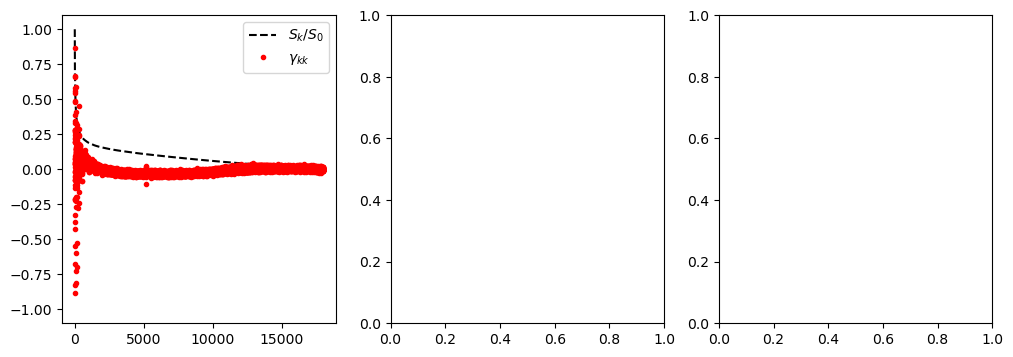

In [4]:
gamma = np.einsum('ij, ki -> jk', U_sk, V_sk.T)
S = s_sk
N = len(S)
H = gamma * gamma.T

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].plot(S/S[0], color='k', linestyle='--')
ax[0].plot(np.diag(gamma), '.', color='r')
ax[0].set_ylim([-1.1, 1.1])
ax[0].legend(['$S_k/S_0$', '$\gamma_{kk}$'])

im = ax[1].imshow(H[:int(f_imshow*N), :int(f_imshow*N)])
ax[1].set_title('$\gamma$')
fig.colorbar(im)

off_diag_idx = np.where(~np.eye(H.shape[0],dtype=bool))
on_diag_idx = np.where(np.eye(H.shape[0],dtype=bool))

H_no_off_diag = np.diag(np.diag(H))
H_no_on_diag = H.copy()
H_no_on_diag[on_diag_idx] = 0

f_on_diag = S.dot(H_no_off_diag).dot(S)/N
f_off_diag = S.dot(H_no_on_diag).dot(S)/N
ax[2].bar(x=[1,2], height=[f_on_diag, f_off_diag])
ax[2].set_xticks([1, 2], ['diag', 'off-diag'])
ax[2].set_title('Contributions to symmetry')

Text(0.5, 1.0, 'Contributions to symmetry')

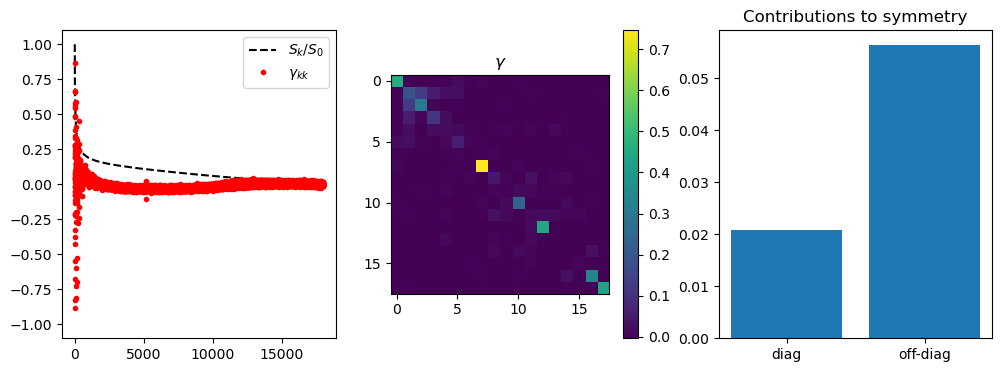

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].plot(S/S[0], color='k', linestyle='--')
ax[0].plot(np.diag(gamma), '.', color='r')
ax[0].set_ylim([-1.1, 1.1])
ax[0].legend(['$S_k/S_0$', '$\gamma_{kk}$'])

f_imshow = 0.001
im = ax[1].imshow(H[:int(f_imshow*N), :int(f_imshow*N)])
ax[1].set_title('$\gamma$')
fig.colorbar(im)

off_diag_idx = np.where(~np.eye(H.shape[0],dtype=bool))
on_diag_idx = np.where(np.eye(H.shape[0],dtype=bool))

H_no_off_diag = np.diag(np.diag(H))
H_no_on_diag = H.copy()
H_no_on_diag[on_diag_idx] = 0

f_on_diag = S.dot(H_no_off_diag).dot(S)/N
f_off_diag = S.dot(H_no_on_diag).dot(S)/N
ax[2].bar(x=[1,2], height=[f_on_diag, f_off_diag])
ax[2].set_xticks([1, 2], ['diag', 'off-diag'])
ax[2].set_title('Contributions to symmetry')

In [6]:
s_sk.dot(np.diag(gamma))

7.247925e-05

In [ ]:
# Participation Ratios

# Compute Participation Ratios
pr_U = 1./np.sum((U_sk[:, :]**2)**2, axis=0)
pr_V = 1./np.sum((V_sk[:, :]**2)**2, axis=0)

# Compute null PR
v = np.random.randn(J.shape[0])
v = v / np.sqrt(np.sum(v**2))
pr_null = 1/np.sum(v**4)

# Plot Participation Ratios
plt.figure(figsize=(10, 6), dpi=300)
plt.plot(gaussian_filter1d(pr_U, sigma=10)[:5000], label='Participation Ratio U', lw=2)
plt.plot(gaussian_filter1d(pr_V, sigma=10)[:5000], label='Participation Ratio V', lw=2)
plt.axhline(pr_null, color='red', linestyle='--', label='Gaussian Random Vector PR')

plt.xlabel('Mode Index')
plt.ylabel('Participation Ratio')
plt.title('Participation Ratios for Singular Vectors')
plt.legend(loc='lower right')
plt.ylim(0, 6200)

plt.savefig("figs/participation_ratios.pdf", bbox_inches='tight')
plt.show()


In [ ]:
# Diagonal of Overlap Matrix and Cumulative PVE

# Calculate necessary values
diag_O = np.diag(O)
n = 2./np.sqrt(J.shape[0])
pve = np.cumsum(s_sk**2)/np.sum(s_sk**2)

# Create subplots
fig, ax = plt.subplots(2, 1, figsize=(10, 8), dpi=300, sharex=True)

# Plot first subplot
ax[0].plot(gaussian_filter1d(diag_O, sigma=10), lw=1)
ax[0].axhline(0, lw=0.3, color='black')
ax[0].axhline(n, lw=0.3, color='black', ls='--', label='$\pm 2/\sqrt{N}$')
ax[0].axhline(-n, lw=0.3, color='black', ls='--')
ax[0].set_ylim(-0.3, 0.3)
ax[0].set_ylabel('Diagonal of O')
ax[0].set_title('Diagonal of Overlap Matrix')
ax[0].legend()

# Plot second subplot
ax[1].plot(pve)
ax[1].set_ylabel('Cumulative PVE')
ax[1].set_xlabel('Singular Mode Index')
ax[1].set_title('Cumulative Proportion of Variance Explained (PVE)')

# Show plot
plt.tight_layout()
plt.savefig("figs/diag_pve.pdf", bbox_inches='tight')
plt.show()


In [ ]:
# Singular Value Distribution

# Calculate necessary values
x, y = np.arange(len(s_sk))+1, s_sk
res = linregress(np.log(x)[50:5000], np.log(y)[50:5000])

# Plot Singular Value Distribution
plt.figure(figsize=(10, 6), dpi=300)
plt.plot(x, y)
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-1, 15)
plt.axvline(50, color='red', linestyle='--')
plt.axvline(5000, color='red', linestyle='--', label='power law fit range')
plt.title(f"Singular Value Distribution (Power = {res.slope:.2f})")
plt.xlabel('Mode Index')
plt.ylabel('Singular Value')
plt.legend()
plt.savefig("figs/singular_value_distribution.pdf", bbox_inches='tight')
plt.show()


In [ ]:
# Number of Unique Brain Regions in Singular Vectors

# Initialize counts array
counts = np.zeros((5000, 4))

# Compute the number of unique brain regions for left and right singular vectors for both incoming and outgoing regions
for i in range(len(counts)):
    counts[i, 0] = len(np.unique(nrn_roi_incoming[np.abs(U_sk[:, i]).argsort()[::-1][:100]]))
    counts[i, 1] = len(np.unique(nrn_roi_incoming[np.abs(V_sk[:, i]).argsort()[::-1][:100]]))
    counts[i, 2] = len(np.unique(nrn_roi_outgoing[np.abs(U_sk[:, i]).argsort()[::-1][:100]]))
    counts[i, 3] = len(np.unique(nrn_roi_outgoing[np.abs(V_sk[:, i]).argsort()[::-1][:100]]))

# Plotting the counts
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(gaussian_filter1d(counts, sigma=5, axis=0))
plt.title('Number of Unique Brain Regions in Singular Vectors')
plt.xlabel('Mode Index')
plt.ylabel('Number of Unique Regions')
plt.legend(['Left Singular Vector (U) Incoming', 'Right Singular Vector (V) Incoming', 
            'Left Singular Vector (U) Outgoing', 'Right Singular Vector (V) Outgoing'])
plt.ylim(0, 30)
plt.tight_layout()
plt.savefig("figs/unique_brain_regions.pdf", bbox_inches='tight')
plt.show()


In [ ]:
# Mode Table

import textwrap as twp

# Create a table-like structure to display region names
w = 35

cell_text = []
columns = ['Mode', 'Left Singular Vector (U) Incoming', 'Right Singular Vector (V) Incoming', 
           'Left Singular Vector (U) Outgoing', 'Right Singular Vector (V) Outgoing']
columns = [twp.fill(c, w) for c in columns]

modes = np.concatenate((np.arange(10), 10+np.arange(9)*10))
for row_idx in range(len(modes)):
    i = modes[row_idx]
    nrns_U = np.abs(U_sk[:, i]).argsort()[::-1][:100]
    nrns_V = np.abs(V_sk[:, i]).argsort()[::-1][:100]
    regions_U_incoming = np.unique(nrn_roi_incoming[nrns_U])
    regions_V_incoming = np.unique(nrn_roi_incoming[nrns_V])
    regions_U_outgoing = np.unique(nrn_roi_outgoing[nrns_U])
    regions_V_outgoing = np.unique(nrn_roi_outgoing[nrns_V])
    
    row = [f'Mode {i}']
    row.append(twp.fill(', '.join(regions_U_incoming), w))
    row.append(twp.fill(', '.join(regions_V_incoming), w))
    row.append(twp.fill(', '.join(regions_U_outgoing), w))
    row.append(twp.fill(', '.join(regions_V_outgoing), w))
    cell_text.append(row)

fig, ax = plt.subplots(figsize=(12, 12))  # Increased figure size for better spacing
ax.axis('off')
table = ax.table(cellText=cell_text, colLabels=columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1, 1.5)

# Adjusting the row heights to prevent content from being cut off
for key, cell in table.get_celld().items():
    cell.set_height(cell.get_height() * 2)  # Adjust the height as necessary

plt.tight_layout()
plt.savefig("figs/mode_table.pdf", bbox_inches='tight')
plt.show()


In [ ]:
N